# gUAcS Examples
The following notebook contains some basic usage of the ``gUAcS`` package. For more details on theory employed please view docs\theory.pdf.

## Imports

In [1]:
from guacs.guacs import (
    trace_rays,
    trace_beams,
    RayConfig,
    BeamConfig,
    ProgConfig,
    EnvConfig,
    SourceConfig,
    Body,
    IsoSpace,
    Ssp,
)
from scipy.interpolate import splrep
import matplotlib.pyplot as plt
from python_utils import (munk_profile, 
                          plot_rays, 
                          plot_pq, 
                        #   animate_propagation
                          )
from datetime import datetime
from IPython.display import HTML

# Setting Performance Expectations
This will either be run on a reasonably powerful desktop or a laptop that struggles to boot.

In [2]:
import platform
import psutil
print(platform.processor())
print(f"Physical Cores: {psutil.cpu_count(logical=False)}")
print(f"Logical Cores: {psutil.cpu_count(logical=True)}")

x86_64
Physical Cores: 2
Logical Cores: 4


## Geometric Ray Tracing
### Setup
For the first simulation a single tone source is considered using the canonical Munk sound speed profile. The programmatic and environmental data must be defined.

Consider a single tone with a single source at 1000m depth. For visualisation purposes reflecting bodies at 0m and 5000m depth are included.

In [3]:
sources = [SourceConfig(range_pos=0.0, depth_pos=1000.0, ray_fan_limits=(
    -0.2, 0.2), n_rays=200, source_level=100, frequency=1000.0)]

bodies = [
    Body(
        range_vals=[0.0, 200000.0, 200000.0, 0.0, 0.0],
        depth_vals=[5000.0, 5000.0, 5100.0, 5100.0, 5000.0],
    ),
    Body(
        range_vals=[0.0, 200000.0, 200000.0, 0.0, 0.0],
        depth_vals=[0.0, 0.0, -1.0, -1.0, 0.0],
    ),
]

With the source and body objects defined. A sound speed profile can now be calculated. This is done by fitting a spline to the canonical Munk profile. The spline knots, coefficients and order are then passed to an ``EnvConfig`` object which the ``gUAcS`` package will use to calculate the sound speed at each depth. The ``EnvConfig`` object also contains a list of the bodies, swell height and ``IsoSpaces`` objects. The use of swell height and ``IsoSpaces`` is not relevant for this initial simulation.

In [4]:
max_depth = 5000
depth_step = 100
ssp_depths = range(-2 * depth_step, max_depth + 3 * depth_step, depth_step)
ssp_vals = [munk_profile(z) for z in ssp_depths]
fitted_spline = splrep(ssp_depths, ssp_vals, k=3)
ssp = Ssp(
    ssp_knots=fitted_spline[0], ssp_coefs=fitted_spline[1], ssp_degree=fitted_spline[2])

env_config = EnvConfig(
    bodies=bodies,
    ssp=ssp,
    swell_height=0.0,
    isospaces=[]
)

Lastly, the programmatic elements of the simulation must be defined. This includes the maximum number of simulation steps, the depth discretisation, range limits, path for output data and a solver selection which is used for beam tracing methods. Following this the overall ``RayConfig`` object can be constructed.

In [5]:
prog_config = ProgConfig(max_it=int(1e5), depth_step=1.0, max_range=2e5,
                         min_range=-1.0, output_path="output_data")

config = RayConfig(prog_config=prog_config,
                env_config=env_config, sources=sources)

### Simulation Running & Display
The ray tracing simulation can be run with a single line call of the ``trace_rays`` function which returns a list of ``Ray`` objects containing the data for each ray path.

In [6]:
t0 = datetime.now()
rays = trace_rays(config)
t = datetime.now() - t0
print(f"Time required to complete simulation: {t}")

Time required to complete simulation: 0:00:01.589993


To viusualise the results call the ``plot_rays`` function.

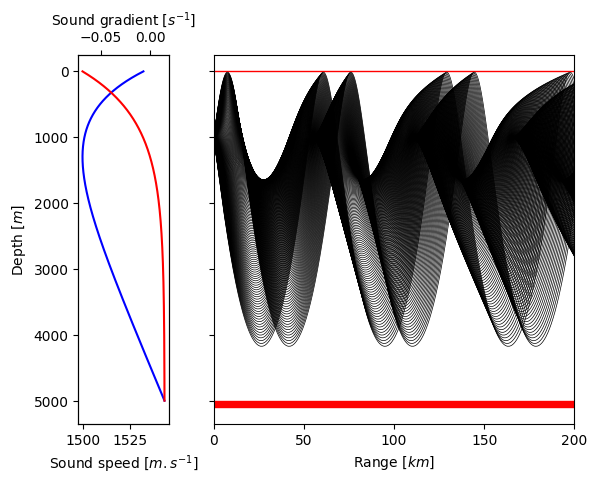

In [7]:
ray_fig = plot_rays(config, rays)
plt.show()

The spatial information for the rays looks convincing but it does not give any indication of the time domain data. For this, the ``animate_propagation`` function  may be used. This is commented out for GitHub to avoid producing a notebook which is too large to view.

In [8]:
# ani = animate_propagation(config, rays, framerate=1, fast_fwd=1)
# HTML(ani.to_jshtml())

### IsoSpace Ray Tracing
As there may be some media which do not have a varying sound speed profile. To simulate these spaces the ``IsoSpace`` class is used. This class has a constant sound speed and density unlike the water column typically analysed. The config defined earlier can now be modified to include an Isospace over the entire solution space. Additionally the total number of rays and maximum number of iterations is reduced as the isospace tracing method differs from the variable sound speed tracing method.

In [9]:
prog_config_iso = ProgConfig(max_it=10, depth_step=1.0, max_range=1e5,
                         min_range=-1.0, output_path="output_data")
sources_iso = [SourceConfig(range_pos=-1.0, depth_pos=1000.0,
                        ray_fan_limits=(-0.1, 0.2), n_rays=1, source_level=150, frequency=1000)]
bodies_iso = []
isospaces_iso = [IsoSpace(body=Body(range_vals=[-1.0, 1e5, 1e5, -1.0, -1.0], depth_vals=[
    0.0, 0.0, 5e3, 5e3, 0.0]), sound_speed=1800.0, density=1000.0)]
env_config_iso = EnvConfig(bodies=bodies_iso, ssp=ssp,
                       swell_height=0.0, isospaces=isospaces_iso)
config_iso = RayConfig(prog_config=prog_config_iso,
                env_config=env_config_iso, sources=sources_iso)

Now run the simulation and view the results.

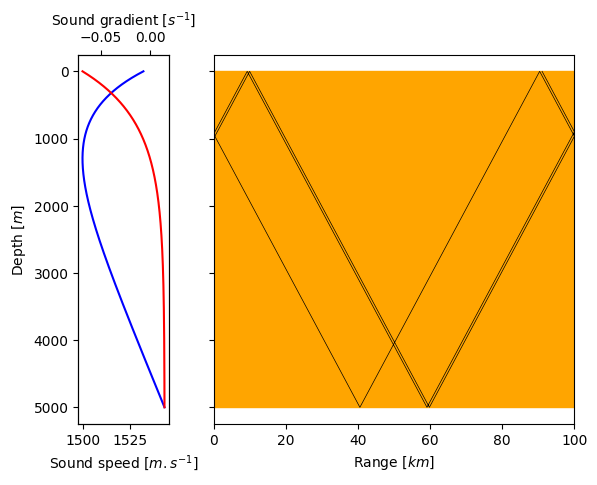

In [10]:
iso_ray = trace_rays(config_iso)
ray_fig = plot_rays(config_iso, iso_ray)
plt.show()

In [11]:
# ani = animate_propagation(config, iso_ray, framerate=1, fast_fwd=1)
# HTML(ani.to_jshtml())

## Beam Tracing
The beam tracing process runs the initial geometric ray tracing algorithm followed by dynamic ray tracing and finally formulation of the beams. The beam intensity calculation is not yet implemented but some details on the DRT system and p-q equation evolution can be included here.

Firstly modify the config file to have a pq equation solver from the selection of "BackwardEuler", "RungeKutta4", "Radau3IA" and "Radau3IIA".

In [12]:
prog_config = ProgConfig(max_it=int(1e5), max_range=2e5, min_range=-1.0,
                         depth_step=1.0, output_path="output_data")
ray_config = RayConfig(prog_config=prog_config,
                env_config=env_config, sources=sources)
beam_config = BeamConfig(ray_config=ray_config, pq_solver="RungeKutta4", pressure_locs=[])

To run the simulation call the ``trace_beams`` function now.

In [13]:
t0 = datetime.now()
beams = trace_beams(beam_config)
t = datetime.now() - t0
print(f"Time required to complete simulation: {t}")

Time required to complete simulation: 0:00:02.742891


By taking the central ray from each beam object the same ray propagation plot can be created as before.

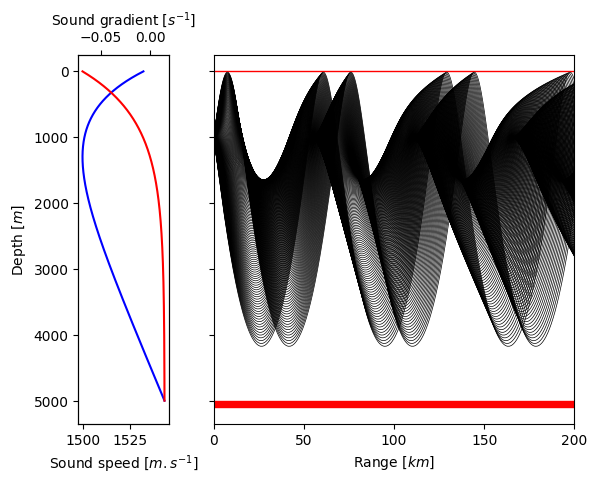

In [14]:
rays = [bm.central_ray for bm in beams]
ray_fig = plot_rays(config, rays)

The p-q variables (as defined in docs\theory.pdf) can also be viewed to determine if the solver is stable.

(0.0, 10.0)

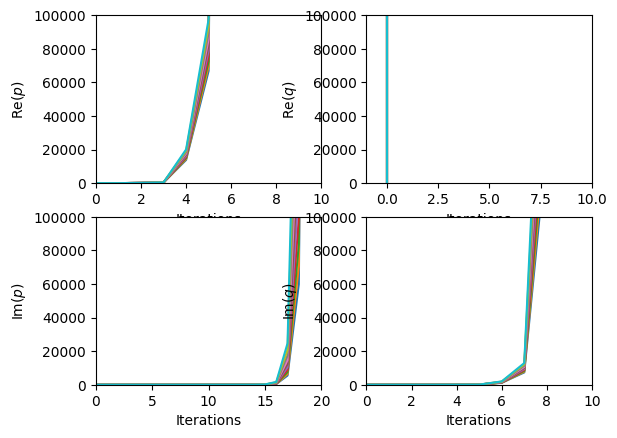

In [15]:
fig = plot_pq(beams[0:10])
fig.axes[0].set_xlim((0, 10))
fig.axes[1].set_xlim((-1, 10))
fig.axes[2].set_xlim((0, 20))
fig.axes[3].set_xlim((0, 10))

By inspection, the RungeKutta4 method is unstable. This is likely as it is an explicit solver. For a better chance, try the "Radau3IIA" method as this is an implicit and stiff solver.

Time required to complete simulation: 0:00:04.248524


(-1e-05, 0.003)

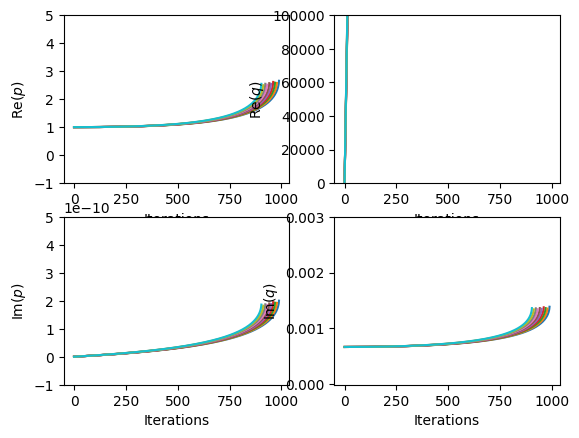

In [16]:
beam_config = BeamConfig(ray_config=ray_config, pq_solver="Radau3IIA", pressure_locs=[])
t0 = datetime.now()
beams = trace_beams(beam_config)
t = datetime.now() - t0
print(f"Time required to complete simulation: {t}")
fig = plot_pq(beams[0:10])
fig.axes[0].set_ylim((-1, 5))
fig.axes[2].set_ylim((-1e-10, 5e-10))
fig.axes[3].set_ylim((-1e-5, 3e-3))

This solver appears to be more stable although there are still significant issues with divergence after ~1000 iterations. Until this stability issue is explained or solved there will be no pressure evaluation within the sound field.